In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
import math
import time
import func3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Writing the data generation:

In [11]:
def batchSeqGen(batchSize, prob, seqLength=None):
    if seqLength == None:
        seqLength = random.randint(3,100)
    batchX = torch.randn(batchSize, seqLength, 10) #implies batch_first=true
    batchY = torch.zeros(batchSize, seqLength)
    changePoints = []
    for i in range(batchSize):
        changePoint = -1
        ind = [0,0,0,0,0]
        offset = torch.zeros(5)
        if random.random() < prob:
            changePoint = random.randint(0,seqLength - 1) 
            ind = random.sample(range(10), 5)
            offset = 2*torch.rand(5) - 1
            for j in range(seqLength):
                if j >= changePoint:
                    batchY[i,j] = 1
                    c = 0
                    for k in ind:
                        batchX[i,j,k] += offset[c]
                        c += 1
        changePoints.append(changePoint)
            
    return batchX, batchY, changePoints     

The LSTM model itself:

In [86]:
class changeDetectLSTM(nn.Module):
    def __init__(self):
        super(changeDetectLSTM, self).__init__()
        hidden_layer_node_num = 60
        hidden_layer_num = 3
        self.lstm = nn.LSTM(10, hidden_layer_node_num, hidden_layer_num ,batch_first=True, bidirectional=True, dropout = 0.1)
        self.layernorm = nn.LayerNorm(hidden_layer_node_num * 2)
        self.linearClassify = nn.Linear(hidden_layer_node_num * 2,1)
    
    def forward(self, seq):
        # seq = torch.mul(seq, 10)
        seq, _ = self.lstm(seq)
        seq = self.layernorm(seq)
        seq = self.linearClassify(seq)
        
        return seq[:,:,0]

The training loop:

In [87]:
model = changeDetectLSTM()
model = model.to(device)
# optimizer = optim.Adam(model.parameters(), lr = 0.0002, weight_decay = 0.001)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
print("Hello")

x_test, y_test, _ = batchSeqGen(100, 1.0, 100)
x_test = x_test.to(device)
y_test = y_test.to(device)
for epoch in range(30):
    totalLoss = 0
    for i in range(2**7):
        x_batch, y_batch, _ = batchSeqGen(40,0.8)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad 
        output = model(x_batch)
        # print(output.shape)
        # print(y_batch[0])
#         print(output.shape)
#         print(y_batch.shape)
        # loss = torch.nn.CrossEntropyLoss()(output, y_batch)
        loss = torch.nn.BCEWithLogitsLoss()(output, y_batch)

        totalLoss += loss.item()
        loss.backward()
        optimizer.step()
            
    # print((epoch+1),"Test loss",torch.nn.CrossEntropyLoss()(model.forward(x_test), y_test).item(), "Training loss", totalLoss)
    print((epoch+1),"Test loss",torch.nn.BCEWithLogitsLoss()(model.forward(x_test), y_test).item(), "Training loss", totalLoss)


Hello
1 Test loss 0.814259946346283 Training loss 95.90843033790588
2 Test loss 0.7165129780769348 Training loss 92.01212483644485
3 Test loss 0.7934954762458801 Training loss 87.75130093097687
4 Test loss 0.6531305313110352 Training loss 87.73425477743149
5 Test loss 0.6679298877716064 Training loss 84.79591619968414
6 Test loss 0.7282071113586426 Training loss 82.458520591259
7 Test loss 0.6607458591461182 Training loss 79.56198900938034
8 Test loss 0.5577471852302551 Training loss 75.1911068558693
9 Test loss 0.7041803002357483 Training loss 75.60557872056961
10 Test loss 0.5940012335777283 Training loss 75.56413868069649
11 Test loss 0.5893265604972839 Training loss 73.0009132027626
12 Test loss 0.49333837628364563 Training loss 64.8179503083229
13 Test loss 0.3892539143562317 Training loss 55.97824762761593
14 Test loss 0.5019086003303528 Training loss 58.271692633628845
15 Test loss 0.4586074650287628 Training loss 51.85948126018047
16 Test loss 0.37558993697166443 Training loss 

In [14]:
def error_present(modeled, T, seq):
    values = []
    for i in range(11):
        if i - 5 + T > 100:
            values.append(1.0)
        else:
            values.append(modeled[i - 5 + T].item())
    plt.scatter([i-5 for i in range(11)], values)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]], device='cuda:0')
tensor([[0.0059, 0.0074, 0.0069, 0.0071, 0.0069, 0.0077, 0.0097, 0.0086, 0.0088,
         0.0095, 0.0091, 0.0123, 0.0107, 0.0094, 0.0101, 0.0130, 0.0133, 0.0110,
         0.0099, 0.0092, 0.0142, 0.0205, 0.0149, 0.0191, 0.0260, 0.0336, 0.0399,
         0.0238, 0.0254, 0.0261, 0.0281, 0.0253, 0.0212, 0.0219, 0.0189, 0.0185,
         0.0191, 0.0163, 0.0159, 0.0139, 0.0191, 0.0212, 0.0203, 0.0177, 0.0156,
         0.0226, 0.0185, 0.0180, 0.0157, 0.0205, 0.0169, 0.0151, 0.0285, 0.0236,
         0.0231, 0.0201, 0.0272, 0.0225, 

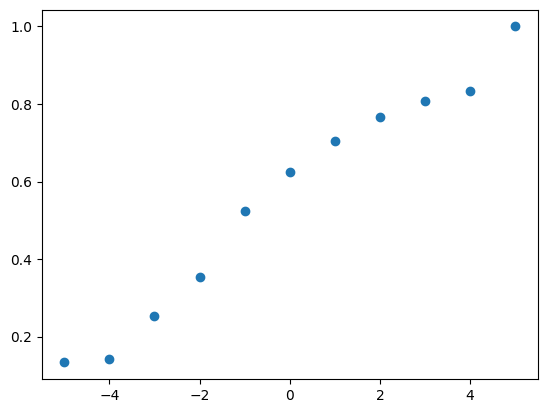

In [85]:

x, y, changePoints = batchSeqGen(1, 1.0, 100)
x = x.to(device)
y = y.to(device)
print(y)
print(nn.Sigmoid()(model.forward(x)))
print(torch.nn.BCEWithLogitsLoss()(model.forward(x), y).item())
modeled = nn.Sigmoid()(model(x))[0]
T = changePoints[0]
seq = y[0]
values = []
for i in range(11):
    if i - 5 + T >= 100:
        values.append(1.0)
    else:
        values.append(modeled[i - 5 + T].item())
plt.scatter([i-5 for i in range(11)], values)
plt.show()
# error_present(nn.Sigmoid()(model(x))[0], changePoints[0], y[0])
            